# Shapley Tests

## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple, List

# Standard Libraries
from enum import Enum, auto
from pathlib import Path
from math import sqrt, pi, sin, cos, tan, radians
from statistics import mean
from itertools import zip_longest
from dataclasses import dataclass, field, asdict

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt

#import PySimpleGUI as sg
import pydicom

import shapely
#from shapely.plotting import plot_polygon, plot_points

#import RS_DICOM_Utilities


### Global Settings

In [2]:
PRECISION = 3


### Contour Creation Functions

In [3]:
def circle_points(radius: float, offset_x: float = 0, offset_y: float = 0,
                  num_points: int = 16, precision=3)->list[tuple[float, float]]:
    deg_step = radians(360/num_points)
    degree_points = np.arange(stop=radians(360), step=deg_step)
    x_coord = np.array([round(radius*sin(d), precision) for d in degree_points])
    y_coord = np.array([round(radius*cos(d), precision) for d in degree_points])

    x_coord = x_coord + offset_x
    y_coord = y_coord + offset_y
    coords = [(x,y) for x,y in zip(x_coord,y_coord)]
    return coords

In [4]:
def box_points(width:float, height: float = None, offset_x: float = 0,
               offset_y: float = 0) -> list[tuple[float, float]]:
    x1_unit = width / 2
    if not height:
        y1_unit = x1_unit
    else:
        y1_unit = height / 2
    coords = [
        ( x1_unit + offset_x,  y1_unit + offset_y),
        ( x1_unit + offset_x, -y1_unit + offset_y),
        (-x1_unit + offset_x, -y1_unit + offset_y),
        (-x1_unit + offset_x,  y1_unit + offset_y)
        ]
    return coords

## StructureSlice Class

In [5]:
class StructureSlice():
    '''Assemble a shapely.MultiPolygon.

    Iteratively create a shapely MultiPolygon from a list of shapely Polygons.
    polygons that are contained within the already formed MultiPolygon are
    treated as holes and subtracted from the MultiPolygon.  Polygons
    overlapping with the already formed MultiPolygon are rejected. Polygons that
    are disjoint with the already formed MultiPolygon are combined with a union.

    Two custom properties exterior and hull are defined. Exterior returns the
    equivalent with all holes filled in.  Hull returns a MultiPolygon that is
    the convex hull surrounding the entire MultiPolygon.

    Args:
        contours (List[shapely.Polygon]): A list of polygons to be merged
        into a single MultiPolygon.

    Attributes:
        contour (shapely.MultiPolygon): The MultiPolygon created by combining
            the supplied list of polygons.
        exterior (shapely.MultiPolygon): The contour MultiPolygon with all
            holes filled in.
        hull (shapely.MultiPolygon): The MultiPolygon that is the convex hull
            surrounding the contour MultiPolygon.
    '''
    def __init__(self, contours: List[shapely.Polygon]) -> None:
        '''Iteratively create a shapely MultiPolygon from a list of shapely
        Polygons.

        Polygons that are contained within the already formed MultiPolygon are
        treated as holes and subtracted from the MultiPolygon.  Polygons
        overlapping with the already formed MultiPolygon are rejected. Polygons
        that are disjoint with the already formed MultiPolygon are combined.

        Args:
            contours (List[shapely.Polygon]): A list of polygons to be merged
            into a single MultiPolygon.
        '''
        self.contour = shapely.MultiPolygon()
        for contour in contours:
            self.add_contour(contour)

    def add_contour(self, contour: shapely.Polygon) -> None:
        '''Add a shapely Polygon to the current MultiPolygon from a list of shapely
        Polygons.

        Polygons that are contained within the already formed MultiPolygon are
        treated as holes and subtracted from the MultiPolygon.  Polygons
        overlapping with the already formed MultiPolygon are rejected. Polygons
        that are disjoint with the already formed MultiPolygon are combined.

        Args:
            contour (shapely.Polygon): The shapely Polygon to be added.
                The shapely Polygon must either be contained in or be disjoint
                with the existing MultiPolygon.

        Raises:
            ValueError: When the supplied shapely Polygon overlaps with the
                existing MultiPolygon.
        '''
        # Check for non-overlapping structures
        if self.contour.disjoint(contour):
            # Combine non-overlapping structures
            new_contours = self.contour.union(contour)
        # Check for hole contour
        elif self.contour.contains(contour):
            # Subtract hole contour
            new_contours = self.contour.difference(contour)
        else:
            raise ValueError('Cannot merge overlapping contours.')
        # Enforce the MultiPolygon type for self.contour
        if isinstance(new_contours, shapely.MultiPolygon):
            self.contour = new_contours
        else:
            self.contour = shapely.MultiPolygon([new_contours])

    @property
    def exterior(self)-> shapely.MultiPolygon:
        '''The solid exterior contour MultiPolygon.

        Returns:
            shapely.MultiPolygon: The contour MultiPolygon with all holes
                filled in.
        '''
        solid = [shapely.Polygon(shapely.get_exterior_ring(poly))
                 for poly in self.contour.geoms]
        return shapely.MultiPolygon(solid)

    @property
    def hull(self)-> shapely.MultiPolygon:
        '''A bounding contour generated from the entire contour MultiPolygon.

        A convex hull can be pictures as an elastic band stretched around the
        external contour.

        Returns:
            shapely.MultiPolygon: The bounding contour for the entire contour
                MultiPolygon.
        '''
        hull = shapely.convex_hull(self.contour)
        return shapely.MultiPolygon([hull])

### Testing the StructureSlice Class

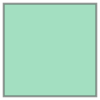

In [6]:
box6 = shapely.Polygon(box_points(6))
a = StructureSlice([box6])
a.contour

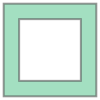

In [7]:
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
a = StructureSlice([box6, box4])
a.contour

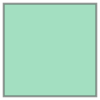

In [8]:
a.exterior

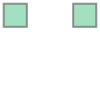

In [9]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
a = StructureSlice([box2a, box2b])
a.contour

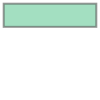

In [10]:
a.hull

In [11]:
### Simple overlap
box6 = shapely.Polygon(box_points(6))
offset_box6 = shapely.Polygon(box_points(6,offset_x=3))
try:
    StructureSlice([box6, offset_box6])
except ValueError as err:
    print(err)

Cannot merge overlapping contours.


In [12]:
# Inverted order
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
try:
    StructureSlice([box4, box6])
except ValueError as err:
    print(err)

Cannot merge overlapping contours.


## Relationship Functions

### Relationship Binary string

In [13]:
def compare(mpoly1: shapely.MultiPolygon,
            mpoly2: shapely.MultiPolygon)->str:
    '''Get the DE-9IM relationship string for two contours

    The relationship string is converted to binary format, where 'F'
    is '0' and '1' or '2' is '1'.

    Args:
        mpoly1 (shapely.MultiPolygon): All contours for a structure on
            a single slice.
        mpoly2 (shapely.MultiPolygon): All contours for a second
            structure on the same slice.

    Returns:
        str: A length 9 string '1's and '0's reflecting the DE-9IM
            relationship between the supplied contours.
    '''
    relation_str = shapely.relate(mpoly1, mpoly2)
    # Convert relationship string in the form '212FF1FF2' into a
    # boolean string.
    relation_bool = relation_str.replace('F','0').replace('2','1')
    return relation_bool

#### Testing compare function

In [14]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
box4 = shapely.MultiPolygon([shapely.Polygon(box_points(4))])
compare(box6, box4)

'111001001'

In [15]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
compare(box6, box6)

'100010001'

In [16]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
compare(box2a, box2b)

'001001111'

### Full 27-bit relationship binary

In [17]:
def relate(contour1: StructureSlice, contour2: StructureSlice)->int:
    '''Get the 27 bit relationship integer for two polygons,

    When written in binary, the 27 bit relationship contains 3 9-bit
    parts corresponding to DE-9IM relationships. The left-most 9 bits
    are the relationship between the second structure's contour and the
    first structure's convex hull polygon. The middle 9 bits are the
    relationship between the second structure's contour and the first
    structure's exterior polygon (i.e. with any holes filled). The
    right-most 9 bits are the relationship between the second
    structure's contour and the first structure's contour.

    Args:
        slice_structures (pd.DataFrame): A table of structures, where
            the values are the contours with type StructureSlice. The
            column index contains the roi numbers for the structures.
            The row index contains the slice index distances.

    Returns:
        int: An integer corresponding to a 27 bit binary value
            reflecting the combined DE-9IM relationship between the
            second contour and the struct1 convex hull, exterior and
            contour.
    '''
    # The tests below may be unnecessary.
#    if not contour2:
#        # If secondary_contour is empty, the primary_contour is outside of the
#        # second structure.
#        full_relation = '001001001' * 3
#    elif not contour1:
#        # If primary_contour is empty, the secondary_contour is outside of the
#        # primary structure.
#        full_relation = '000000111' * 3
#    else:
    primary_relation = compare(contour1.contour, contour2.contour)
    external_relation = compare(contour1.exterior, contour2.contour)
    convex_hull_relation = compare(contour1.hull, contour2.contour)
    full_relation = ''.join([convex_hull_relation,
                                external_relation,
                                primary_relation])
    binary_relation = int(full_relation, base=2)
    return binary_relation

#### Testing relate function

In [18]:
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
a = StructureSlice([box6])
b = StructureSlice([box4])
bin(relate(a,b))

'0b111001001111001001111001001'

In [19]:
box6 = shapely.Polygon(box_points(6))
a = StructureSlice([box6])
bin(relate(a,a))

'0b100010001100010001100010001'

In [20]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
a = StructureSlice([box2a])
b = StructureSlice([box2b])
bin(relate(a,b))

'0b1001111001001111001001111'

## Named Relationship Identification

### Relationship Type Definitions

In [21]:
class RelationshipType(Enum):
    '''The names for defines relationship types.'''
    DISJOINT = auto()
    SURROUNDS = auto()
    SHELTERS = auto()
    BORDERS = auto()
    CONFINES = auto()
    OVERLAPS = auto()
    INCORPORATES = auto()
    CONTAINS = auto()
    EQUALS = auto()
    LOGICAL = auto()
    UNKNOWN = 999  # Used for initialization

    def __bool__(self):
        if self == self.UNKNOWN:
            return False
        return True


#### Testing RelationshipType

In [22]:
bool(RelationshipType.UNKNOWN)

False

In [23]:
bool(RelationshipType.LOGICAL)

True

### Relationship Test Class

In [24]:
@dataclass()
class RelationshipTest:
    '''The test binaries used to identify a relationship type.

    Each test definitions consists of 2 27-bit binaries, a mask and a value.
    Each of the 27-bit binaries contain 3 9-bit parts associated with DE-9IM
    relationships. The left-most 9 bits are associated with the relationship
    between one structure's convex hull and another structure's contour. The
    middle 9 bits are associated with the relationship between the first
    structure's exterior polygon (i.e. with any holes filled) and the second
    structure's contour. The right-most 9 bits are associated with the
    relationship between first structure's contour and the second structure's
    contour.

    Named relationships are identified by logical patterns such as: T*T*F*FF*
        The 'T' indicates the bit must be True.
        The 'F' indicates the bit must be False.
        The '*' indicates the bit can be either True or False.
    Ane example of a complete relationship logic is:
    Surrounds (One structure resides completely within a hole in another
               structure):
        Region Test =   FF*FF****  - The contours of the two structures have no
                                     regions in common.
        Exterior Test = T***F*F**  - With holes filled, one structure is within
                                     the other.
        Hull Test =     *********  - Together, the Region and Exterior Tests
                                     sufficiently identifies the relationship,
                                     so the Hull Test is not necessary.
    The mask binary is a sequence of 0s and 1s with every '*' as a '0' and every
    'T' or 'F' bit as a '1'.  The operation: relationship_integer & mask will
    set all of the bit that are allowed to be either True or False to 0.

    The value binary is a sequence of 0s and 1s with every 'T' as a '1' and
    every '*' or 'F' bit as a '0'. The relationship is identified when value
    binary is equal to the result of the `relationship_integer & mask`
    operation.
    '''
    relation_type: RelationshipType = RelationshipType.UNKNOWN
    mask: int = 0b000000000000000000000000000
    value: int = 0b000000000000000000000000000

    def __repr__(self) -> str:
        rep_str = ''.join([
            f'RelationshipTest({self.relation_type}\n',
            ' ' * 4,
            f'mask =  0b{self.mask:0>27b}\n',
            ' ' * 4,
            f'value = 0b{self.value:0>27b}'
            ])
        return rep_str

    def test(self, relation: int)->RelationshipType:
        masked_relation = relation & self.mask
        if masked_relation == self.value:
            return self.relation_type
        return None


### Relationship Test Definitions

In [25]:
def identify_type(relation_binary) -> RelationshipType:
    '''Applies a collection of definitions for named relationships to a supplied
    relationship binary.

    The defined relationships are:
        Relationship      Region Test   Exterior Test   Hull Test
        Disjoint          FF*FF****     FF*FF****       FF*FF****
        Shelters          FF*FF****     FF*FF****       T***F*F**
        Surrounds         FF*FF****     T***F*F**
        Confines          FF*FT****     T***T****
        Borders           FF*FT****     FF*FT****
        Contains	      T*T*F*FF*
        Incorporates	  T*T*T*FF*
        Equals	          T*F**FFF*
        Overlaps          TTTT*TTT*

    Args:
        relation_binary (int): An integer generated from the combined DE-9IM
            tests.

    Returns:
        RelationshipType: The identified RelationshipType if one of the tests
            passes, otherwise RelationshipType.UNKNOWN.
    '''
    # Relationship Test Definitions
    test_binaries = [
        RelationshipTest(RelationshipType.OVERLAPS,
            0b000000000000000000111101110,
            0b000000000000000000111101110),
        RelationshipTest(RelationshipType.EQUALS,
            0b000000000000000000101001110,
            0b000000000000000000100000000),
        RelationshipTest(RelationshipType.INCORPORATES,
            0b000000000000000000101010110,
            0b000000000000000000101010000),
        RelationshipTest(RelationshipType.CONTAINS,
            0b000000000000000000101010110,
            0b000000000000000000101000000),
        RelationshipTest(RelationshipType.CONFINES,
            0b000000000101010110110110000,
            0b000000000101000000000010000),
        RelationshipTest(RelationshipType.BORDERS,
            0b000000000110110000110110000,
            0b000000000000010000000010000),
        RelationshipTest(RelationshipType.SHELTERS,
            0b100010100110110000110110000,
            0b000000000000000000100000000),
        RelationshipTest(RelationshipType.SURROUNDS,
            0b000000000100010110110110000,
            0b000000000100000000000000000),
        RelationshipTest(RelationshipType.DISJOINT,
            0b110110000110110000110110000,
            0b000000000000000000000000000)
        ]
    for rel_def in test_binaries:
        result = rel_def.test(relation_binary)
        if result:
            return result
    return RelationshipType.UNKNOWN


def compare(mpoly1: shapely.MultiPolygon,
            mpoly2: shapely.MultiPolygon)->str:
    '''Get the DE-9IM relationship string for two contours

    The relationship string is converted to binary format, where 'F'
    is '0' and '1' or '2' is '1'.

    Args:
        mpoly1 (shapely.MultiPolygon): All contours for a structure on
            a single slice.
        mpoly2 (shapely.MultiPolygon): All contours for a second
            structure on the same slice.

    Returns:
        str: A length 9 string '1's and '0's reflecting the DE-9IM
            relationship between the supplied contours.
    '''
    relation_str = shapely.relate(mpoly1, mpoly2)
    # Convert relationship string in the form '212FF1FF2' into a
    # boolean string.
    relation_bool = relation_str.replace('F','0').replace('2','1')
    return relation_bool

#### Testing identify_type function

### Contains

In [26]:
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
a = StructureSlice([box6])
b = StructureSlice([box4])
print(identify_type(relate(a,b)))

RelationshipType.CONTAINS


### Equals

In [27]:
box6 = shapely.Polygon(box_points(6))
a = StructureSlice([box6])
print(identify_type(relate(a,a)))

RelationshipType.EQUALS


### Disjoint

In [28]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
a = StructureSlice([box2a])
b = StructureSlice([box2b])
print(identify_type(relate(a,b)))

RelationshipType.DISJOINT


### Missing Polygon

In [29]:
box6 = shapely.Polygon(box_points(6))
box0 = shapely.Polygon()
a = StructureSlice([box6])
b = StructureSlice([box0])
print(identify_type(relate(a,b)))

RelationshipType.DISJOINT


# Relationship Types and Definitions

<ul style="font-weight: 900; font-size: 20px;">
<li style="color: blue;">region a</li>
<li style="color: green;">region b</li>
<li style="color: orange;">intersection of a & b</li></ul>


## Disjoint Relations


### Surrounds/ Embeds
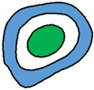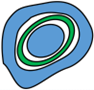
<style>
    .matrix {position: relative; border-collapse: collapse;}
    .matrix:before, .matrix:after {
        content: "";
        position: absolute;
        top: 0;
        border: 3px solid #000;
        width: 10px;
        height: 100%;
    }
    .matrix:before {
        left: -6px;
        border-right: 0;
    }
    .matrix:after {
        right: -6px;
        border-left: 0;
    }
    .relation {border-style: hidden; font-style: italic; font-weight: bold;padding: 0px 15px 0px 15px;}
</style>
<table>
<thead><th>Region</th><th>Exterior</th><th>Hull</th></thead>
<tbody>
<tr>
<td style="padding: 10px"><table class="matrix" style="border-style: hidden;">        
<tr class="relation">
    <td class="relation">F</td><td class="relation">F</td><td class="relation">*</td></tr>
<tr class="relation">
    <td class="relation">F</td><td class="relation">F</td><td class="relation">*</td></tr>
<tr class="relation">
    <td class="relation">*</td><td class="relation">*</td><td class="relation">*</td></tr>
</table>
</tbody>


## Reference binaries

In [4]:
missing_other = 0b001001001
missing_primary = 0b000000111

contains_mask = 0b101010110
contains_value = 0b101000000

within_mask = 0b101011100
within_value = 0b100000100


### Contains

212FF1FF2
0b111001001
0b101000000
Contains: True


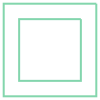

In [5]:
box6 = Polygon(box_points(6))
box4 = Polygon(box_points(4))

contains = shapely.relate(box6, box4)
print(contains)

# Make binary
contains_str = contains.replace('F','0').replace('2','1')
contains_bin = int(contains_str, base=2)

# Slices with box6 but not box4
combined_bin = contains_bin | missing_other
print(bin(combined_bin))

# OR of slices
print(bin(combined_bin & contains_mask))
print('Contains:', (combined_bin & contains_mask) == contains_value)

shapely.union(box6.boundary, box4.boundary)

### Within

2FF1FF212
0b100100111
0b100000100
Within: True


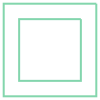

In [6]:
within =shapely.relate(box4, box6)
print(within)


# Make binary
within_str = within.replace('F','0').replace('2','1')
within_bin = int(within_str, base=2)

# Slices with box6 but not box4
combined_bin = within_bin | missing_primary
print(bin(combined_bin))

# OR of slices
print(bin(combined_bin & within_mask))
print('Within:', (combined_bin & within_mask) == within_value)

shapely.union(box6.boundary, box4.boundary)

### Equals

2FFF1FFF2


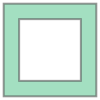

In [7]:
box6 = Polygon(box_points(6))
box4 = Polygon(box_points(4))
hollow_box = shapely.difference(box6, box4)
print(shapely.relate(hollow_box, hollow_box))
hollow_box

In [8]:
fig = plt.figure(1, figsize=(2,1))
ax = fig.add_subplot(121)
ax.set_axis_off()
ax.axis('equal')
p = plot_polygon(hollow_box, ax=ax, add_points=True, color='red')

### Simple overlap

212111212


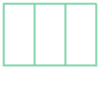

In [9]:
box6 = Polygon(box_points(6))
offset_box6 = Polygon(box_points(6,offset_x=3))
print(shapely.relate(box6, offset_box6))

shapely.union(box6.boundary, offset_box6.boundary)

212101212


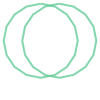

In [10]:
circle_6 = Polygon(circle_points(6))
offset_circle_6 = Polygon(circle_points(6,offset_x=3))
print(shapely.relate(circle_6, offset_circle_6))

shapely.union(circle_6.boundary, offset_circle_6.boundary)

- *2121**1**1212* 
- > ***1*** because the boundaries overlap
- *2121**0**1212* 
- > ***0*** because the boundaries only cross

### Borders 

#### Borders Exterior 

In [11]:
box6_right = Polygon(box_points(6, offset_x=6))
box4_right = Polygon(box_points(4, offset_x=6))
hollow_box_right = shapely.difference(box6_right, box4_right)
#hollow_box_right

In [12]:
box4_inside = Polygon(box_points(2, 3.5, offset_x=-1))
box2_inside = Polygon(box_points(1, 3, offset_x=-1))
hollow_box_inside = shapely.difference(box4_inside, box2_inside)
#hollow_box_inside

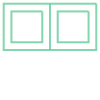

In [13]:
shapely.relate(hollow_box, hollow_box_right)
shapely.union(hollow_box.boundary, hollow_box_right.boundary)

FF2F11212


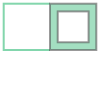

In [14]:
shape = Polygon(hollow_box.exterior)
print(shapely.relate(shape, hollow_box_right))
shapely.union(hollow_box.exterior, hollow_box_right)


FF2FF1212


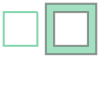

In [15]:
shape = Polygon(hollow_box.interiors[0])
print(shapely.relate(shape, hollow_box_right))
shapely.union(hollow_box.interiors[0], hollow_box_right)


#### Borders Interior 

In [18]:
shape = Polygon(hollow_box.interiors[0])
print(shapely.relate(shape, hollow_box_inside))


212F11FF2


212FF1FF2


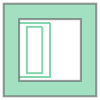

In [19]:
print(shapely.relate(shapely.Polygon(shapely.get_exterior_ring(hollow_box)),
                     hollow_box_inside))
shapely.union(hollow_box, hollow_box_inside.boundary)


In [ ]:
shapely.get_exterior_ring(poly)

#### Filled Interior

FF2F112F2
212F1FFF2


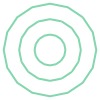

In [14]:
circle_6 = Polygon(circle_points(6))
circle_4 = Polygon(circle_points(4))
circle_2 = Polygon(circle_points(2))
island_shape = shapely.union(shapely.difference(circle_6, circle_4),circle_2)
island_border = shapely.difference(circle_4, circle_2)

print(shapely.relate(island_shape, island_border))

interior = Polygon(island_shape.geoms[0].interiors[0])
print(shapely.relate(interior, island_border))
shapely.union(island_shape.boundary, island_border.boundary)

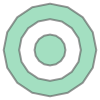

In [15]:
circle_6 = Polygon(circle_points(6))
circle_4 = Polygon(circle_points(4))
circle_2 = Polygon(circle_points(2))
island = shapely.union(shapely.difference(circle_6, circle_4),circle_2)
island

In [16]:
offset_circle_6 = Polygon(circle_points(6,offset_x=6))
offset_circle_4 = Polygon(circle_points(4,offset_x=6))
offset_circle_2 = Polygon(circle_points(2,offset_x=6))
offset_island = shapely.union(shapely.difference(offset_circle_6, offset_circle_4),offset_circle_2)


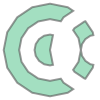

In [17]:
shapely.difference(island, offset_island)

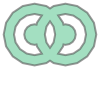

In [18]:
shapely.union(island, offset_island)

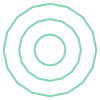

In [19]:
offset_island.boundary

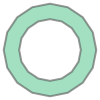

In [20]:
a = [g for g in offset_island.geoms]
a[0]

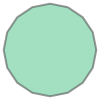

In [21]:
a[1]

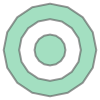

In [22]:
island

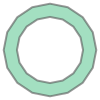

In [23]:
circle_35 = Polygon(circle_points(3.5))
circle_25 = Polygon(circle_points(2.5))
hollow = shapely.difference(circle_35, circle_25)
hollow

FF2FF1212


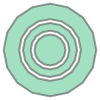

In [24]:
print(shapely.relate(island, hollow))
shapely.union(island, hollow)

212FF1FF2


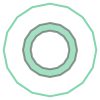

In [25]:
shape = Polygon(island.geoms[0].exterior)
print(shapely.relate(shape, hollow))
shapely.union(island.geoms[0].exterior, hollow)


212FF1FF2


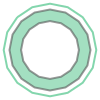

In [26]:
shape = Polygon(island.geoms[0].interiors[0])
print(shapely.relate(shape, hollow))
shapely.union(island.geoms[0].interiors[0], hollow)


FF2FF1212


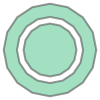

In [27]:
shape = Polygon(island.geoms[1])
print(shapely.relate(shape, hollow))
shapely.union(island.geoms[1], hollow)


# Read Structure with Islands from DICOM


### File Paths

In [28]:
base_path = Path.cwd()
data_path = base_path / 'Test Data'
dicom_path = data_path / r'StructureVolumeTests\SingleContours'

In [29]:
structure_names_file = dicom_path / 'RS.GJS_Struct_Tests.Islands.dcm'

In [30]:
RS_DICOM_Utilities.get_structure_file_info(structure_names_file)

{'PatientName': 'StructureVolumes^Test',
 'PatientLastName': 'StructureVolumes',
 'PatientID': 'GJS_Struct_Tests',
 'StructureSet': 'Islands',
 'StudyID': 'Phantom7',
 'SeriesNumber': '0',
 'File': WindowsPath("d:/OneDrive - Queen's University/Python/Projects/StructureRelations/Test Data/StructureVolumeTests/SingleContours/RS.GJS_Struct_Tests.Islands.dcm")}

In [31]:
dataset = pydicom.dcmread(structure_names_file)

In [32]:
roi_id = RS_DICOM_Utilities.get_names_nums(dataset)
roi_id

1            BODY
14         Island
16    WithIslands
17          Hole1
18        Island1
19          Hole2
20        Island2
Name: StructureID, dtype: object

In [33]:
a = [roi for roi in dataset.ROIContourSequence]

In [34]:
roi = a[2]
structure_num = roi.ReferencedROINumber
hasattr(roi, 'ContourSequence')

True

In [35]:
contours = []
holes = []
for contour_points in roi.ContourSequence:
    points = np.array(contour_points.ContourData).reshape(-1,3)
    points = points / 10  # Convert from mm to cm
    contour = Polygon(points)
    if contour.exterior.is_ccw:
        contours.append(contour)
    else:
        holes.append(contour)

1. sort holes & contours by decreasing area
2. Create polygon from largest contour
3. if next largest is contour and is not contained in polygon combine it otherwise postpone it
4. if next largest is hole and is contained in polygon subtract it otherwise postpone it
5. repeat for all holes & contours, revisiting postponed holes & contours.

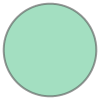

In [36]:
shapely.union_all(contours)


In [37]:
contour_points = b[3]
points = np.array(contour_points.ContourData).reshape(-1,3)
points = points / 10  # Convert from mm to cm
contour = Polygon(points)
contour.exterior.is_ccw

NameError: name 'b' is not defined